# **A 7-taps re-programmable Finite Impulse Response filter on FPGA**
## **demo** - switching runtime the filter coefficients

#### project for MAPD module A - A.Y. 2021/22, University of Padua

*Barone Francesco Pio*

In this notebook we will use a template waveform to test the FIR filter as both lowpass & highpass filter. We will use the built-in functionality to change runtime the parameters of the FIR filter.

In order to achieve this result, we will call some scripts to:
- program the FPGA without using the Vivado UI,
- send the coefficients to FPGA through UART,
- feed the waveform data to the fir-filter through UART.

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
## define the I/O ##
usb_int = '/dev/ttyUSB1'

# data directory
dir_files = './demo/switch/'
# waveform to test:
template_waveform_file = dir_files + 'waveform_sample_sine.txt'
# fpga outputs
fpga_waveform1 = dir_files + 'fpga_sampling1.txt'
fpga_waveform2 = dir_files + 'fpga_sampling2.txt'

In [3]:
# general properties of the FIR filter
sampling_frequency = 200   #  [Hz] frequency of the sampled signals 
taps = 7                   # number of taps  (note: taps = filter_order + 1 )
cutoff_frequency = 30      #  [Hz]
bit_scaling = 7            # number of bits to scale the (float) coefficients & round them to int
fpga_scaling = 8           # FPGA implemented scaling
delay_fpga_processing = 4  # delay from the fpga sample processing

### programming the FPGA

Call Vivado from command line & load the predefined bitstream. We suggest to put the FIR in *programming mode* (SW0 closed, red led steady).

In [4]:
!./tools/program_fpga.sh


****** Vivado v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source script.tcl
# open_hw
# connect_hw_server
INFO: [Labtools 27-2285] Connecting to hw_server url TCP:localhost:3121
INFO: [Labtools 27-2222] Launching hw_server...
INFO: [Labtools 27-2221] Launch Output:

****** Xilinx hw_server v2018.3
  **** Build date : Dec  6 2018-23:53:53
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.


# open_hw_target
INFO: [Labtoolstcl 44-466] Opening hw_target localhost:3121/xilinx_tcf/Digilent/210319A43311A
# set_property PROGRAM.FILE {../bit/fir_switch.bit} [current_hw_device]  
# program_hw_devices [current_hw_device]
INFO: [Labtools 27-3164] End of startup status: HIGH
# close_hw_target
INFO: [Labtoolstcl 44-464] Closing hw_target localhost:3121/xilinx_tcf/Digilent/210319A43311A
# exit
INFO: [Common 17-206] Exiting Vivado at Sat Jan 22 

## **lowpass filter**

The lowpass coefficients are computed using a scipy function (firwin). Then the coefficients are sent to the FPGA.

In [5]:
is_lowpass = True
h = np.array( signal.firwin(taps, cutoff_frequency, fs=sampling_frequency, pass_zero=is_lowpass ) ) 
h_scaled = np.rint( h*(2**bit_scaling) )
print('FIR coefficients:', h_scaled)

FIR coefficients: [ 0.  8. 32. 48. 32.  8.  0.]


![fpga_programming](img/fpga_mode_programming.png)

**NOTE**: Run the following cell while the FPGA is in *programming mode* (SW0 closed, red led active). If the operation is successful, the led should turn purple.

In [6]:
!./tools/write_coefficients.py --usb $usb_int -c 0 8 32 48

 >> using interface /dev/ttyUSB1
 >> coefficients:  [ 0  8 32 48]
 << serial >>
.
.
.
.
>> end of buffer


![fpga_filter](img/fpga_mode_filter.png)
**NOTE**: Now switch the FPGA to *filter mode* (SW0 opened, green led active).

In [7]:
!./tools/send_data_fpga.py -i $template_waveform_file -o $fpga_waveform1

 >> using interface /dev/ttyUSB1
 === ./demo/switch/waveform_sample_sine.txt  -> FPGA ->  ./demo/switch/fpga_sampling1.txt ===
 > read values from file ./demo/switch/waveform_sample_sine.txt
 > 207 values acquired
 << serial >>
.
.
.
.
.
.
.
.
.
.
.
>> end of buffer


#### waveform visualization

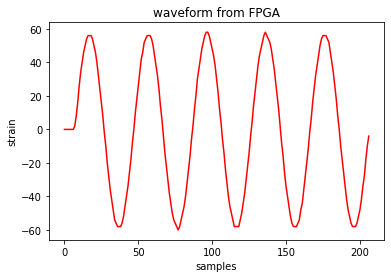

In [8]:
fpga_wave = np.loadtxt(fpga_waveform1)
fpga_wave = fpga_wave * (2**(fpga_scaling-bit_scaling))

plt.plot( np.arange(len(fpga_wave)), fpga_wave, label='FPGA real', color='r') # real FPGA
plt.xlabel('samples'); plt.ylabel('strain'); plt.title('waveform from FPGA');
plt.show()

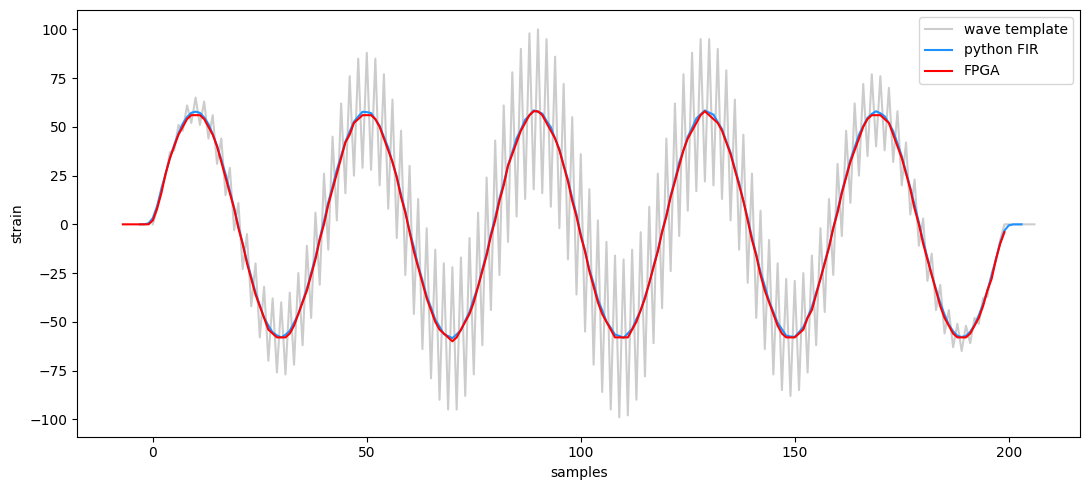

In [9]:
template_file = template_waveform_file
wf_template = np.loadtxt(template_file)

# python simulated FIR filter of coefficients h
py_fir_waveform = signal.lfilter(h, 1.0, wf_template)
delay = int( .5*taps )  # set phase delay of the filtered signal * sample_rate

# plot
plt.figure( figsize=(11,5), dpi=100 )

# waveform from template file
plt.plot( np.arange(len(wf_template)), wf_template, alpha=0.2, label='wave template', color='k')

# python fir
plt.plot( np.arange(len(py_fir_waveform))-delay, py_fir_waveform, label='python FIR', color='dodgerblue')

# real FPGA
plt.plot( np.arange(len(fpga_wave))-delay_fpga_processing-delay, fpga_wave, label='FPGA', color='r')

plt.xlabel('samples'); plt.ylabel('strain');
plt.legend(); plt.tight_layout(); plt.show();

## **highpass filter**

In this section we will use the same filter specifications as above, but we compute the coefficients in order to have an highpass filter.

In [10]:
is_lowpass = False
h = np.array( signal.firwin(taps, cutoff_frequency, fs=sampling_frequency, pass_zero=is_lowpass ) ) 
h_scaled = np.rint( h*(2**bit_scaling) )
print('FIR coefficients:', h_scaled)

FIR coefficients: [ -0.  -6. -25.  89. -25.  -6.  -0.]


**NOTE**: run te following cell while the FPGA is in *programming mode* (SW0 closed, red led active). If the operation is successful, the led should turn purple.

In [11]:
!./tools/write_coefficients.py --usb $usb_int -c 0 -6 -25 89

 >> using interface /dev/ttyUSB1
 >> coefficients:  [  0  -6 -25  89]
 << serial >>
.
.
.
.
>> end of buffer


**NOTE**: Now switch the FPGA to *filter mode* (SW0 opened, green led active).

In [12]:
!./tools/send_data_fpga.py --usb $usb_int -i $template_waveform_file -o $fpga_waveform2

 >> using interface /dev/ttyUSB1
 === ./demo/switch/waveform_sample_sine.txt  -> FPGA ->  ./demo/switch/fpga_sampling2.txt ===
 > read values from file ./demo/switch/waveform_sample_sine.txt
 > 207 values acquired
 << serial >>
.
.
.
.
.
.
.
.
.
.
.
>> end of buffer


#### waveform visualization

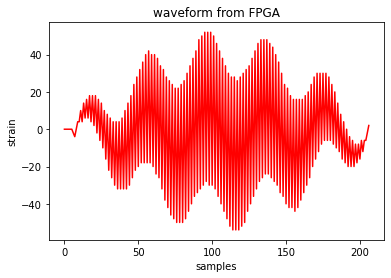

In [13]:
fpga_wave = np.loadtxt(fpga_waveform2)
fpga_wave = fpga_wave * (2**(fpga_scaling-bit_scaling))

plt.plot( np.arange(len(fpga_wave)), fpga_wave, label='FPGA real', color='r') # real FPGA
plt.xlabel('samples'); plt.ylabel('strain'); plt.title('waveform from FPGA');
plt.show()

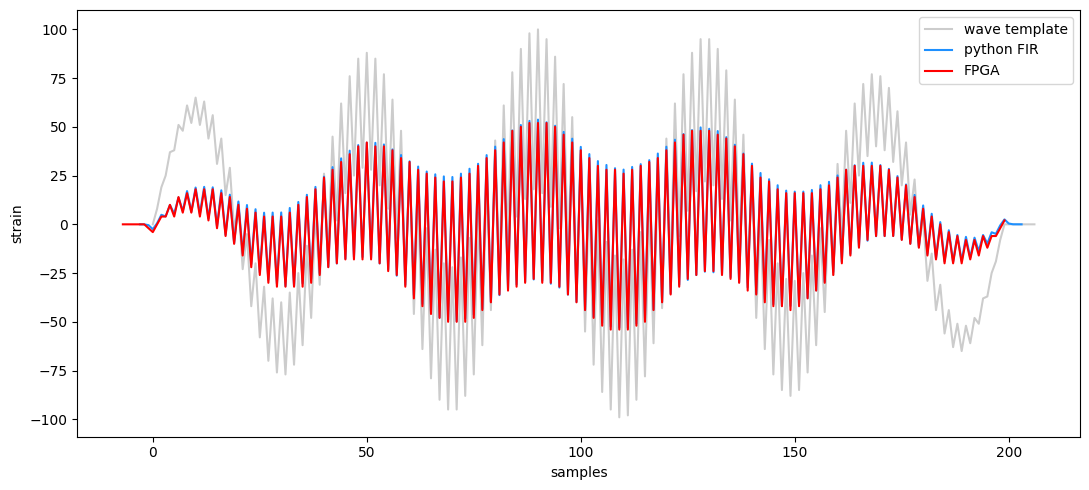

In [14]:
template_file = template_waveform_file
wf_template = np.loadtxt(template_file)

# python simulated FIR filter of coefficients h
py_fir_waveform = signal.lfilter(h, 1.0, wf_template)
delay = int( .5*taps )  # set phase delay of the filtered signal * sample_rate

# plot
plt.figure( figsize=(11,5), dpi=100 )

# waveform from template file
plt.plot( np.arange(len(wf_template)), wf_template, alpha=0.2, label='wave template', color='k')

# python fir
plt.plot( np.arange(len(py_fir_waveform))-delay, py_fir_waveform, label='python FIR', color='dodgerblue')

# real FPGA
plt.plot( np.arange(len(fpga_wave))-delay_fpga_processing-delay, fpga_wave, label='FPGA', color='r')

plt.xlabel('samples'); plt.ylabel('strain');
plt.legend(); plt.tight_layout(); plt.show();

End of demo.